[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gabrielkasmi/ot_gan_ensae/blob/master/autodiff_ot_gan_checkpoint.ipynb)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
!pip install torchviz #git+https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot
!pip install POT
import ot

     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=21826bed48dfb878e27fc87b6c002910e26a717961888f649e9b913700ccb883
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
     |████████████████████████████████| 430kB 8.1MB/s 


In [0]:
# check if cuda is available. if so, send the necessary stuff to the GPU
# warning : some cells/functions are only designed to work with Cuda
cuda = torch.cuda.is_available()

### Definition of the model, import of the database

The model for the MLP is the same as in the paper. Two input neurons, a hidden layer with 500 units and an output layer with 784 units. We choose the ReLU activation function.

In [0]:
class MultilayerPerceptron(nn.Module):
    """
    A MLP with 1 hidden layer
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        """
    Constructor of the MLP.
    Arguments:
    - input_size : number of neurons in the first layer 
    (aka latent space dimension)
    - hidden_size : number of neurons in the hidden layer
    - outout_size : number of neurons in the last layer
        """
        super(MultilayerPerceptron, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.hidden = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.output = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        # self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        hidden = self.hidden(x)
        relu = self.relu(hidden)
        output = self.output(relu)
        # output = self.sigmoid(output)
        # output = self.relu(output)
        return output
    

In [0]:
# Plot the graph of the network
x = torch.rand(2)
test = MultilayerPerceptron(2, 500, 28*28)
# make_dot(test.forward(x)).render('img/mlp_architecture')

In [0]:
# Helper to plot the images

def imshow(img):
    """
    takes a tensor as input and returns an image
    """
    if cuda:
      np_img = img.detach().cpu().numpy()
    else:
      np_img = img.detach().numpy()
    plt.imshow(np.reshape(np_img,(28,28)), cmap='gray_r' )
    plt.show()

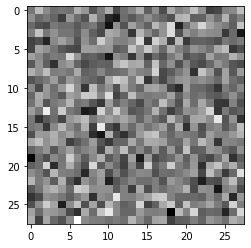

In [10]:
# for i in range(10):
#     imshow(test.forward(x[i,:]))
imshow(test.forward(x))

As it can be seen above, without training the model essentialy generates noise. 

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!



/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


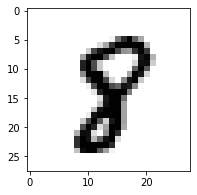

In [11]:
# import the dataset

transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)



# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 512

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

dataiter = iter(train_loader)
images, labels = dataiter.next()

images_np = images.numpy()


# get one image from the batch
img = np.squeeze(images_np[np.random.randint(len(images))])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray_r')
plt.show()

### A first benchmark with a simple $\ell_2$ loss

We first want to see whether the model works, i.e. is able to learn. To do so, we first try to learn using a simple loss and see if the results are consistent. 

In [15]:
# test if the network is training as expected on a dummy example
# should generate an "average" image

if cuda:  
  test = MultilayerPerceptron(2, 500, 784).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(test.parameters(), lr = 0.02) # same optimizer as in the paper

z_size = 2
test.train()
epochs = 25 # not necessary to put many epochs
samples_evolution = []
losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1 # rescale the images
        real_images = real_images.view(-1, 28*28).cuda()
                
        optimizer.zero_grad()
        # Forward pass
        z = torch.rand((batch_size,z_size), requires_grad=True).cuda()
        y_pred = test(z).cuda()
            
        # Compute Loss 
        loss = criterion(y_pred, real_images) # this loss will be replaced by the sinkhorn loss
   
        
        # Backward pass
        loss.backward()
        optimizer.step()
    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    losses.append(loss.item())
    if epoch%10==0:    
        # add an image to the list to see the improvements
        print('Generating an image after %s epochs' %epoch)
        x = torch.rand(2, requires_grad=True).cuda()
        samples_evolution.append(test.forward(x))

Epoch 0: train loss: 0.25680
Generating an image after 0 epochs
Epoch 1: train loss: 0.25609
Epoch 2: train loss: 0.25722
Epoch 3: train loss: 0.25740
Epoch 4: train loss: 0.25739
Epoch 5: train loss: 0.25633
Epoch 6: train loss: 0.25544
Epoch 7: train loss: 0.25500
Epoch 8: train loss: 0.25509
Epoch 9: train loss: 0.25516
Epoch 10: train loss: 0.25526
Generating an image after 10 epochs
Epoch 11: train loss: 0.25540
Epoch 12: train loss: 0.25585
Epoch 13: train loss: 0.25666
Epoch 14: train loss: 0.25710
Epoch 15: train loss: 0.25681
Epoch 16: train loss: 0.25699
Epoch 17: train loss: 0.25740
Epoch 18: train loss: 0.25766
Epoch 19: train loss: 0.25811
Epoch 20: train loss: 0.25841
Generating an image after 20 epochs
Epoch 21: train loss: 0.25874
Epoch 22: train loss: 0.25898
Epoch 23: train loss: 0.25901
Epoch 24: train loss: 0.25900


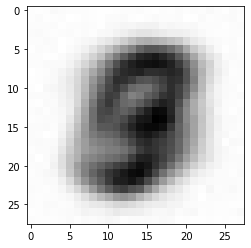

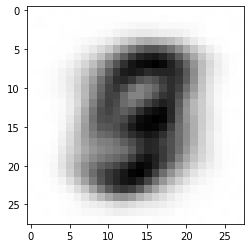

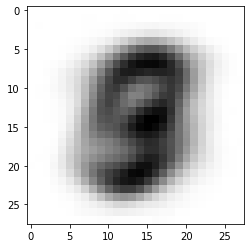

In [16]:
# plot the images generated over training
for img in samples_evolution:
  imshow(img)

As expected, when evaluating against a batch of images, we end up generating "average" images.

We now turn to an even simpler example where the algorithm only learns one image. The result sould be that no matter the input, the same image is returned as an output.

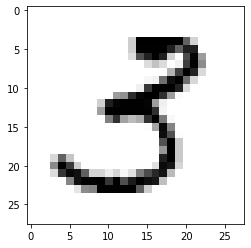

In [14]:
# definition of the target image
target = real_images[0]
imshow(target)

In [17]:
# test if the network is training as expected on a dummy example
# even simpler test, overfit to one image.


if cuda:  
  test = MultilayerPerceptron(2, 500, 784).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(test.parameters(), lr = 0.02) # same optimizer as in the paper

z_size = 2
test.train()
epochs = 10 # not necessary to put many epochs
# samples_evolution = []
#losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1 # rescale the images
        real_images = real_images.view(-1, 28*28).cuda()
                
        optimizer.zero_grad()
        # Forward pass
        z = torch.rand((batch_size,z_size), requires_grad=True).cuda()
        y_pred = test(z).cuda()
            
        # Compute Loss 
        loss = criterion(y_pred, target.cuda()) # this loss will be replaced by the sinkhorn loss
   
        
        # Backward pass
        loss.backward()
        optimizer.step()
    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    #losses.append(loss.item())
    #if epoch%10==0:    
        # add an image to the list to see the improvements
        #print('Generating an image after %s epochs' %epoch)
        #x = torch.rand(2, requires_grad=False).cuda()
        #samples_evolution.append(test(x))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([784])) that is different to the input size (torch.Size([512, 784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([784])) that is different to the input size (torch.Size([96, 784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: train loss: 0.00013
Epoch 1: train loss: 0.00003
Epoch 2: train loss: 0.00001
Epoch 3: train loss: 0.00001
Epoch 4: train loss: 0.00001
Epoch 5: train loss: 0.00000
Epoch 6: train loss: 0.00000
Epoch 7: train loss: 0.00000
Epoch 8: train loss: 0.00000
Epoch 9: train loss: 0.00000


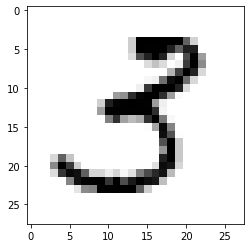

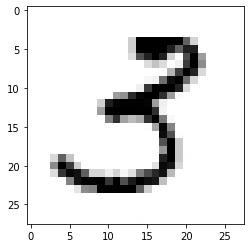

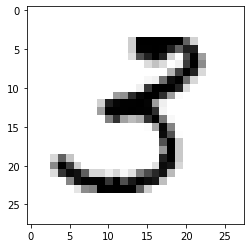

In [20]:
# generate some random vectors and some images 
# copies of the original image are indeed generated.

z = torch.rand(3,2).cuda()
target_copies = test.forward(z)

for img in target_copies:
  imshow(img)



### OT-GAN implementation

The model seems to be working. 

In this section, we define our own loss based on Sinkhorn algorithm and replace it into the learning loop. 

#### Definition of the functions

Three blocks are needed : a cost matrix, the sinkhorn loop and a wrapper that computes the sinkhorn loss $\bar{W}(\mu,\nu) = 2 W(\mu,nu) - W(\mu,\mu) - W(\nu,\nu)$

In [0]:
def cosine_matrix2(x,y):
  """
  computes the cosine similarity between batches x and y 
  """

  # get the batch size
  bs = x.size()[0]
  bs2 = y.size()[0]

  assert bs == bs2, 'batch sizes %s and %s are not the same' % (bs, bs2)

  # initialize and populate the cost matrix
  C = torch.ones((bs,bs)).cuda()

  for i in range(bs):
    for j in range(bs):
      x_lin = x[i,:].unsqueeze(0).cuda()
      y_col = y[j,:].unsqueeze(0).cuda()
      C[i,j] -= F.cosine_similarity(x_lin,y_col).item()

  return C

In [0]:
# cost matrices : l2 norm and cosine distance

def cost_matrix(x, y, normalize = True):
  """
  returns the matric of |x_i-y_j|^2

  x, y : batch tensors

  normalize : true to normalize weights
  """

  
  # reshape the tensors from (bs, n) to (n, bs) 
  # for the computations 
  bs, n = x.size()
  bs2, m = y.size()
    
  x = x.view(n, bs).cuda()
  y = y.view(m, bs2).cuda()


  # compute the cost
  x_col = x.unsqueeze(-2)
  y_lin = y.unsqueeze(-3)
  C = torch.sum((torch.abs(x_col - y_lin)) ** 2, -1)

  if normalize:
    return C/max(1,C.max())

  else : 
    return C

def cosine_matrix(x,y,eps = 1e-5):
  """
  computes the cosine similarity matrix between x and y

  arguemnts:
  x, y : batches
  eps : added to avoid nans

  returns a matrix 

  """
  # reshape the tensors from (bs, n) to (n, bs) 
  # for the computations 
  bs, n = x.size()
  bs2, m = y.size()
    
  x = x.view(n, bs).cuda()
  y = y.view(m, bs2).cuda()

  return 1 - torch.mm(x,y.t())/ max(torch.norm(x, p=2)*torch.norm(y, p=2), eps)


In [0]:
# sinkhorn loop

def sinkhorn_distance(C, epsilon = 0.01, max_iters = 100):
  """
  Compute the sinkhorn distance between batch vectors x and y

  input : cost matrix C

  outputs : a scalar corresponding to the cost
  """

  # dimensions of the data (should be the same in our case)
  n, m = C.size()

  # Kernel matrix
  K = torch.exp(-C/epsilon).cuda()

  # Sinkhorn iterates
  a = torch.ones(m).cuda()
  b = torch.ones(n).cuda()

  #actual loop 
  v = torch.ones(n).cuda()
  for _ in range(max_iters):
    u = a / torch.mv(K,v).cuda()
    v = b / torch.mv(K.t(), u).cuda()

  M = torch.matmul(torch.matmul(torch.diag(u),K),torch.diag(v)).cuda()
  return torch.sum(M*C)


In [0]:
def sinkhorn_loss(x, y, epsilon = 0.1, max_iters = 50 ,normalize = True, cost = 'cosine'):
  """
  Wrapper of the two functions, returns the sinkorn loss between
  batches x and y

  cost : to be chosen between euclidean and cosine 
  """

  if cost == 'euclidean':

    # l2 norm cost matrices 
    C_xy = cost_matrix(x, y, normalize = normalize)
    C_xx = cost_matrix(x, x, normalize = normalize)
    C_yy = cost_matrix(y, y, normalize = normalize)

  elif cost == 'cosine':
    # cosine cost matrix
    C_xy = cosine_matrix(x, y)
    C_xx = cosine_matrix(x, x)
    C_yy = cosine_matrix(y, y)

  # losses

  W_xy = sinkhorn_distance(C_xy, epsilon = epsilon, max_iters = max_iters)
  W_xx = sinkhorn_distance(C_xx, epsilon = epsilon, max_iters = max_iters)
  W_yy = sinkhorn_distance(C_yy, epsilon = epsilon, max_iters = max_iters)

  return 2 * W_xy - W_xx - W_yy

#### Tests on the functions 

Before turning to the training of the model, we test our functions to see if they work properly.

In [0]:
untrained = MultilayerPerceptron(2,500,28*28).cuda()
z_init = torch.rand(512,2).cuda()
y_rand = untrained.forward(z_init)

In [139]:
# checks that the loss is nonnegative and decreasing
print(sinkhorn_loss(y_rand, real_images), sinkhorn_loss(y_rand,y_rand))


tensor(0.1806, device='cuda:0', grad_fn=<SubBackward0>) tensor(0., device='cuda:0', grad_fn=<SubBackward0>)


#### First try 

In [144]:
# train the model with the custom loss

cuda = torch.cuda.is_available()
                                 
if cuda:  
  model2 = MultilayerPerceptron(2, 500, 784).cuda()

# training with custom loss
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.02) # same optimizer as in the paper
                                                             # for the mnist experiment
z_size = 2
batch_size = 512
model2.train()
epochs = 100
samples_evolution_sk = []
losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        #with torch.no_grad():
        batch_size = real_images.size(0)
        #real_images = real_images*2 - 1 # rescale the images
        real_images = real_images.view(-1, 28*28)
        if cuda : 
          real_images.cuda()
                
        optimizer.zero_grad()
        
        # Forward pass
        z = torch.rand((batch_size,z_size), requires_grad=True)
        if cuda :
          z = z.cuda()

        y_pred = model2(z)
            
        # Compute Loss 
        loss = sinkhorn_loss(y_pred, real_images, epsilon = 0.1) # set epsilon to 1, otherwise can lead
                                                               # to instabilities and nans

        # Backward pass
        loss.backward()
        optimizer.step()
    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    losses.append(loss.item())
    if epoch%10==0:    
        # add an image to the list to see the improvements (if any)
        print('Generating an image after %s epochs' %epoch)
        x = torch.rand(2, requires_grad=False).cuda()
        samples_evolution_sk.append(model2(x))

Epoch 0: train loss: 0.00140
Generating an image after 0 epochs
Epoch 1: train loss: 0.00153
Epoch 2: train loss: 0.00146
Epoch 3: train loss: 0.00140
Epoch 4: train loss: 0.00195
Epoch 5: train loss: 0.00165
Epoch 6: train loss: 0.00159
Epoch 7: train loss: 0.00140
Epoch 8: train loss: 0.00116
Epoch 9: train loss: 0.00134
Epoch 10: train loss: 0.00134
Generating an image after 10 epochs
Epoch 11: train loss: 0.00116
Epoch 12: train loss: 0.00104
Epoch 13: train loss: 0.00122
Epoch 14: train loss: 0.00104
Epoch 15: train loss: 0.00085
Epoch 16: train loss: 0.00128
Epoch 17: train loss: 0.00092
Epoch 18: train loss: 0.00104
Epoch 19: train loss: 0.00098
Epoch 20: train loss: 0.00098
Generating an image after 20 epochs
Epoch 21: train loss: 0.00110
Epoch 22: train loss: 0.00073
Epoch 23: train loss: 0.00110
Epoch 24: train loss: 0.00110
Epoch 25: train loss: 0.00098
Epoch 26: train loss: 0.00098
Epoch 27: train loss: 0.00098
Epoch 28: train loss: 0.00104
Epoch 29: train loss: 0.00110
Epo

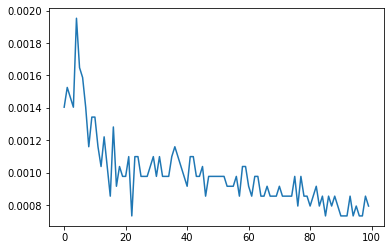

In [145]:
# plot some samples and the loss
plt.plot(losses)
plt.savefig('cosine_losses_100e_one_hidden_layer.png') 

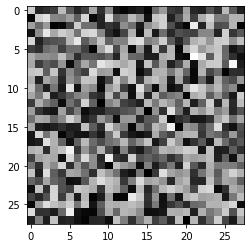

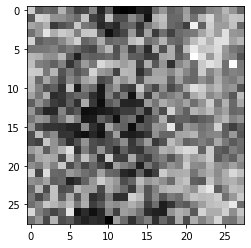

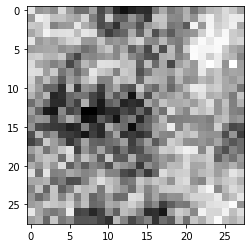

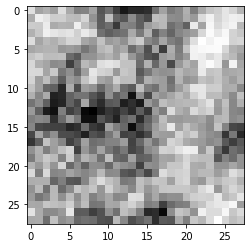

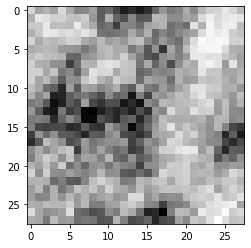

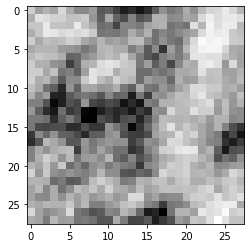

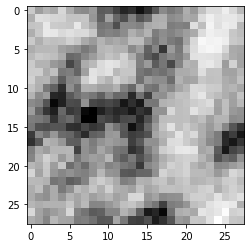

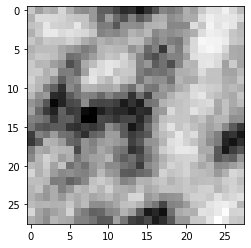

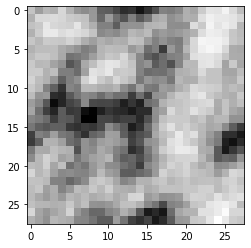

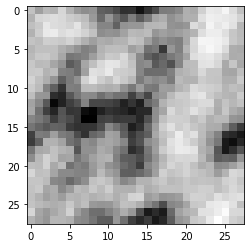

In [146]:
for img in samples_evolution_sk:
  imshow(img)

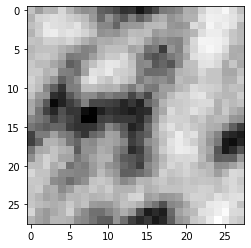

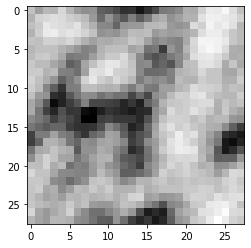

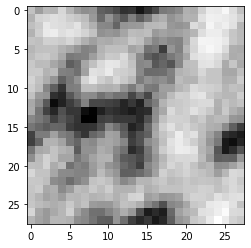

In [148]:
x = torch.rand(3,2).cuda()
generated_images = model2.forward(x)
for img in generated_images:
  imshow(img)
# not really a mnist digit, but not noise either

It appears that the model is indeed learning ; the loss is also decreasing over the epochs, which seems to be encouraging. However the results are not very satisfying. 

#### Second try

We introduce a modification on the cosine cost matrix, should give better results

In [0]:
def cosine_matrix3(x,y):
  """
  computes the cosine similarity between batches x and y 
  """

  # get the batch size
  bs = x.size()[0]
  bs2 = y.size()[0]

  assert bs == bs2, 'batch sizes %s and %s are not the same' % (bs, bs2)

  C = torch.mm(x.cuda(),y.t().cuda()) / (torch.norm(x).cuda() * torch.norm(y).cuda())
  return (1 - C).cuda()


In [0]:
def sinkhorn_loss2(x, y, epsilon = 0.1, max_iters = 50 ,normalize = True, cost = 'cosine'):
  """
  Wrapper of the two functions, returns the sinkorn loss between
  batches x and y

  cost : to be chosen between euclidean and cosine 
  """

  if cost == 'euclidean':

    # l2 norm cost matrices 
    C_xy = cost_matrix(x, y, normalize = normalize)
    C_xx = cost_matrix(x, x, normalize = normalize)
    C_yy = cost_matrix(y, y, normalize = normalize)

  elif cost == 'cosine':
    # cosine cost matrix
    C_xy = cosine_matrix3(x, y)
    C_xx = cosine_matrix3(x, x)
    C_yy = cosine_matrix3(y, y)

  # losses

  W_xy = sinkhorn_distance(C_xy, epsilon = epsilon, max_iters = max_iters)
  W_xx = sinkhorn_distance(C_xx, epsilon = epsilon, max_iters = max_iters)
  W_yy = sinkhorn_distance(C_yy, epsilon = epsilon, max_iters = max_iters)

  return 2 * W_xy - W_xx - W_yy

In [180]:
untrained = MultilayerPerceptron(2,500,28*28).cuda()
z_init = torch.rand(512,2).cuda()
y_rand = untrained.forward(z_init)

# checks that the loss is nonnegative and decreasing
print(sinkhorn_loss2(y_rand, real_images), sinkhorn_loss2(y_rand,y_rand))


tensor(1.2962, device='cuda:0', grad_fn=<SubBackward0>) tensor(0., device='cuda:0', grad_fn=<SubBackward0>)


In [181]:
# train the model with the custom loss

cuda = torch.cuda.is_available()
                                 
if cuda:  
  model3 = MultilayerPerceptron(2, 500, 784).cuda()

# training with custom loss
optimizer = torch.optim.Adam(model3.parameters(), lr = 0.02) # same optimizer as in the paper
                                                             # for the mnist experiment
z_size = 2
batch_size = 512
model2.train()
epochs = 100
samples_evolution_sk = []
losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        #with torch.no_grad():
        batch_size = real_images.size(0)
        #real_images = real_images*2 - 1 # rescale the images
        real_images = real_images.view(-1, 28*28)
        if cuda : 
          real_images.cuda()
                
        optimizer.zero_grad()
        
        # Forward pass
        z = torch.rand((batch_size,z_size), requires_grad=True)
        if cuda :
          z = z.cuda()

        y_pred = model3(z)
            
        # Compute Loss 
        loss = Variable(sinkhorn_loss2(y_pred, real_images, epsilon = 0.1), requires_grad = True) 
                                                              # set epsilon to 0.1, otherwise can lead
                                                               # to instabilities and nans

        # Backward pass
        loss.backward()
        optimizer.step()
    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    losses.append(loss.item())
    if epoch%10==0:    
        # add an image to the list to see the improvements (if any)
        print('Generating an image after %s epochs' %epoch)
        x = torch.rand(2, requires_grad=False).cuda()
        samples_evolution_sk.append(model3.forward(x))

Epoch 0: train loss: 1.29376
Generating an image after 0 epochs
Epoch 1: train loss: 1.29155
Epoch 2: train loss: 1.29143
Epoch 3: train loss: 1.28985
Epoch 4: train loss: 1.29459
Epoch 5: train loss: 1.28315
Epoch 6: train loss: 1.29798
Epoch 7: train loss: 1.29247
Epoch 8: train loss: 1.29279
Epoch 9: train loss: 1.29822
Epoch 10: train loss: 1.28845
Generating an image after 10 epochs
Epoch 11: train loss: 1.28981
Epoch 12: train loss: 1.29190
Epoch 13: train loss: 1.29107
Epoch 14: train loss: 1.29839
Epoch 15: train loss: 1.28325
Epoch 16: train loss: 1.29282
Epoch 17: train loss: 1.28539
Epoch 18: train loss: 1.29298
Epoch 19: train loss: 1.29274
Epoch 20: train loss: 1.29230
Generating an image after 20 epochs
Epoch 21: train loss: 1.29993
Epoch 22: train loss: 1.28532
Epoch 23: train loss: 1.28672
Epoch 24: train loss: 1.28886
Epoch 25: train loss: 1.29553
Epoch 26: train loss: 1.30620
Epoch 27: train loss: 1.29234
Epoch 28: train loss: 1.29382
Epoch 29: train loss: 1.28926
Epo

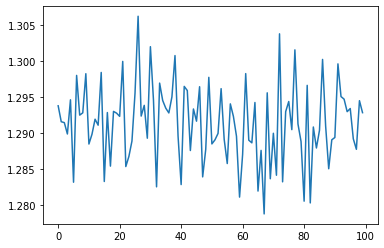

In [182]:
# plot some samples and the loss
plt.plot(losses)
plt.savefig('cosine_losses_100e_one_hidden_layer_batch_matrix.png') 
# doesn't really seem to be learning at all

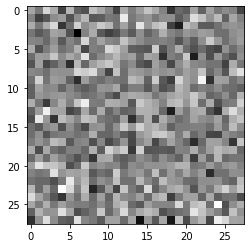

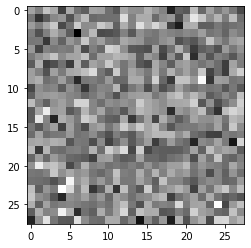

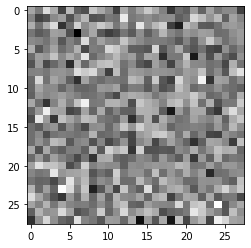

In [183]:
x = torch.rand(3,2).cuda()
generated_images = model3.forward(x)
for img in generated_images:
  imshow(img)


Its getting worse... Try, again, with a $\ell_2$ loss over the batches to see if there is any improvement

#### Thrid try

Change again the cost matrix, to be the $\ell_2$ distances over the batches

In [0]:
def cost_matrix4(x,y, normalize = True):
  """
  euclidean cost matrix between batches 
  """

  if normalize: 
    return C/max(1,C.max())
  else:
    return C